<a href="https://colab.research.google.com/github/haytham918/low-rank-expectile/blob/main/LRE_wt_BFGS_Simulates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from scipy.stats import norm
from scipy.optimize import minimize
import time


In [ ]:
def normal_data_generator(m, n, r_sd, c_sd, u_sd, v_sd, sigma, na_portion, rank, random_seed):
  """
  Generator function for normal simulated data:
  m: The Number of Rows of Feature Matrix(i.e. number of users)
  n: The Number of Columns of Feature Matrix(i.e. number of items)
  r_sd: The standard deviation of true_r
  c_sd: The standard deviation of true_c
  u_sd: The standard deviation of true_u
  v_sd: The standard deviation of true_v
  sigma: The noise standard deviation
  na_proportion: Proportion of missing data
  rank: (k), The rank for model
  random_seed: self-explained
  """
  np.random.seed(random_seed)
  k = rank

  true_r = norm.rvs(loc=0, size=m, scale=r_sd)
  true_c = norm.rvs(loc=0, size=m, scale=c_sd)

  true_u = norm.rvs(loc=0, size=(m, k), scale=u_sd)
  true_v = norm.rvs(loc=0, size=(n, k), scale=v_sd)

  sigma = sigma

  mu_X = true_r[:, np.newaxis] + true_c + np.dot(true_u, true_v.T)

  error = sigma * norm.rvs(size=(m, n))
  X = mu_X + error

  prob_miss = na_portion
  missing = np.random.choice([True, False], size=(m, n), p=[prob_miss, 1 - prob_miss])
  X[missing] = np.nan
  return X, true_r, true_c, true_u, true_v


Configuration 1:

* Matrix Size: 200 * 200
* True R Mean: 40
* True R SD: 1
* True C Mean: 40
* True C SD: 1
* True U/V Mean: 0
* True U/V STD: 0.1
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 2
* Seed: 100



In [ ]:
#-----------------
# Configuration 1:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 2
# Seed: 100
#-----------------

X_config1, true_r_config1, true_c_config1, true_u_congfig1, true_v_config1 = normal_data_generator(m=200, n=200, r_sd=1, c_sd=1, u_sd=1, v_sd=1,sigma=0.3,na_portion=0.3,rank=2,random_seed=100)
#plt.hist(np.dot(true_u, true_v.T).flat)
#plt.hist((true_r[:, np.newaxis] + true_c ).flat)
masked_array = np.ma.masked_array(X_config1, np.isnan(X_config1))
# X_nona = X[M]
mean_nona = np.mean(masked_array)
std_val = np.std(masked_array)
X_normalized = X_config1 - mean_nona
X_normalized /= std_val
print("MEAN", mean_nona)
print("STD: ", std_val)
print("NEW ERROR_SD: ", 0.3/std_val )
print(X_normalized)
X_new = X_normalized[~np.isnan(X_normalized)]
print("NEW MEAN: ", np.mean(X_new))
print("NEW STD: ", np.std(X_new))

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  4.049830354859505e-18
NEW STD:  1.0


In [ ]:
def get_observed_mask(X):
    return ~np.isnan(X)

def compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau):
    m, n = X.shape
    k = U.shape[1]

    # Construct approximation and error matrices
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    # Get weight
    W = np.where(error_matrix >= 0, tau, 1 - tau)

    # Calculate gradient
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    return R_grad, C_grad, U_grad, V_grad

def expectile_loss_vectorized(X, R, C, U, V, M, tau):
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()

    return loss

def expectile_gradient_descent_vectorized(X, k, epochs, eta, tau):
    m, n = X.shape
    R = np.zeros(m)
    C = np.zeros(n)
    U = np.random.normal(0, 0.1, (m, k))
    V = np.random.normal(0, 0.1, (n, k))
    M = get_observed_mask(X)

    for epoch in range(epochs):
        R_grad, C_grad, U_grad, V_grad = compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau)
        R -= eta * R_grad
        C -= eta * C_grad
        U -= eta * U_grad
        V -= eta * V_grad

        if epoch % 10 == 9:
            current_loss = expectile_loss_vectorized(X, R, C, U, V, M, tau)
            print(f"Epoch {epoch+1}: Loss = {current_loss}")

    return R, C, U, V

In [ ]:
def flatten_parameters(R, C, U, V):
    return np.concatenate([R, C, U.flatten(), V.flatten()])

def unflatten_parameters(params, m, n, k):
    R = params[:m]
    C = params[m:m+n]
    U = params[m+n:m+n+m*k].reshape(m, k)
    V = params[m+n+m*k:].reshape(n, k)
    return R, C, U, V

def total_loss_and_gradient(params, X, M, tau, m, n, k, loss_array):
    R, C, U, V = unflatten_parameters(params, m, n, k)
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()
    loss_array.append(loss)
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    grad = flatten_parameters(R_grad, C_grad, U_grad, V_grad)
    return loss, grad

# BFGS METHOD, set method to "L-BFGS-B" for LBFGS
# Init all parameters one time
def optimize_with_bfgs_all_init(X, k, tau, loss_array, mu, sd, method="BFGS"):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(mu, sd, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method=method, jac=True, options={'disp': False, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"{method} Final Loss: {final_loss}")
    return R, C, U, V

# Initi parameters separately
# def optimize_with_bfgs_sep_init(X, k, tau, loss_array, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd, method="BFGS"):
#     m, n = X.shape
#     M = get_observed_mask(X)
#     initial_r_param = np.random.normal(r_mu, r_sd, m)
#     initial_c_param = np.random.normal(c_mu, c_sd, n)
#     initial_u_param = np.random.normal(u_mu, u_sd, m*k)
#     initial_v_param = np.random.normal(v_mu, v_sd, n*k)
#     initial_params = np.concatenate((initial_r_param, initial_c_param, initial_u_param, initial_v_param))

#     result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
#                       method='BFGS', jac=True, options={'disp': False, "maxiter": 500})

#     final_params = result.x
#     final_loss = result.fun
#     R, C, U, V = unflatten_parameters(final_params, m, n, k)
#     print(f"{method} Final Loss: {final_loss}")
#     return R, C, U, V


In [ ]:
def runner_all_init(setup_num, config_matrix, rank, tau, loss_array, lbfgs_loss_array, mu, sd):
  start_time = time.time()
  R, C, U, V = optimize_with_bfgs_all_init(config_matrix, rank, tau, loss_array, mu, sd)
  end_time = time.time()
  bfgs_iter_num = len(loss_array)
  print(f"Trial {setup_num} BFGS Takes about: ", end_time - start_time, " (s)")
  print(f"Trial {setup_num} BFGS Iterations: ", bfgs_iter_num)
  print("------------------------------------")

  # LBFGS
  lbfgs_start_time = time.time()
  lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V = optimize_with_bfgs_all_init(config_matrix, rank, tau, lbfgs_loss_array, mu, sd, "L-BFGS-B")
  lbfgs_end_time = time.time()
  lbfgs_iter_num = len(lbfgs_loss_array)
  print(f"Trial {setup_num} LBFGS Takes about: ", lbfgs_end_time - lbfgs_start_time, " (s)")
  print(f"Trial {setup_num} LBFGS Iterations: ", lbfgs_iter_num)
  print("")

  return R, C, U, V, lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V

# def runner_sep_init(setup_num, config_matrix, rank, tau, loss_array, lbfgs_loss_array, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd):
#   start_time = time.time()
#   R, C, U, V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, loss_array, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd)
#   end_time = time.time()
#   bfgs_iter_num = len(loss_array)
#   print(f"SETUP {setup_num} BFGS Takes about: ", end_time - start_time, " (s)")
#   print(f"SETUP {setup_num} BFGS Iterations: ", bfgs_iter_num)
#   print("------------------------------------")

#   # LBFGS
#   lbfgs_start_time = time.time()
#   lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, lbfgs_loss_array, r_mu, r_sd, c_mu, c_sd, u_mu, u_sd, v_mu, v_sd, "L-BFGS-B")
#   lbfgs_end_time = time.time()
#   lbfgs_iter_num = len(lbfgs_loss_array)
#   print(f"SETUP {setup_num} LBFGS Takes about: ", lbfgs_end_time - lbfgs_start_time, " (s)")
#   print(f"SETUP {setup_num} LBFGS Iterations: ", lbfgs_iter_num)

#   return R, C, U, V, lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V

def plotter(setup_num, loss_array, lbfgs_loss_array):
  bfgs_horizontal = np.arange(1, len(loss_array) + 1)
  lbfgs_horizontal = np.arange(1, len(lbfgs_loss_array) + 1)
  bfgs_log = np.log(loss_array)
  lbfgs_log = np.log(np.array(lbfgs_loss_array))
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].set_ylabel("LOSS")
  axs[0].set_xlabel("Number of Iterations")
  axs[0].set_title(f"SETUP {setup_num}'s LOSS v.s. Iterations")
  axs[0].plot(bfgs_horizontal, loss_array, label="BFGS", color='r')
  axs[0].plot(lbfgs_horizontal, lbfgs_loss_array, label="LBFGS", color='b')
  axs[0].legend()


  axs[1].set_ylabel("LOG LOSS")
  axs[1].set_xlabel("Number of Iterations")
  axs[1].set_title(f"SETUP {setup_num}'s LOG LOSS v.s. Iterations")
  axs[1].plot(bfgs_horizontal, bfgs_log, label="BFGS", color='r')
  axs[1].plot(lbfgs_horizontal, lbfgs_log, label="LBFGS", color='b')
  axs[1].legend()

# SETUP  
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 0
* True R SD: 1
* True C Mean: 0
* True C SD: 1
* True U/V Mean: 0
* True U/V STD: 1
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 2
* Seed: 100

Initialization:
* All INIT
* Mu: 0
* SD: 0.3

Expectile:
* Tau: 0.6

In [ ]:
# SETUP 1:
#----------
# Configuration: 1
# Initialization: ALL, Mu: 0, SD: 1
# Tau: 0.6
#----------
rank_1 = 2
tau_1 = 0.6
mu_1 = 0
sd_1 = 1
# TODO: SET SD to be fixed values(1) and run the algorithm in several iterations
# Compare their results(loss_value), Recover the fitted values
# Compare them with the difference between every pair of interations(10 choose 2)

all_bfgs_loss_arrays = []
all_lbfgs_loss_arrays = []
all_bfgs_final_loss = []
all_lbfgs_final_loss = []
all_bfgs_predict_array = []
all_lbfgs_predict_array = []
for i in range(10):
  bfgs_loss_array = []
  lbfgs_loss_array = []
  R, C, U, V, l_R, l_C, l_U, l_V = runner_all_init(i, X_normalized, rank_1, tau_1, bfgs_loss_array, lbfgs_loss_array, mu_1, sd_1)
  all_bfgs_final_loss.append(bfgs_loss_array[-1])
  all_lbfgs_final_loss.append(lbfgs_loss_array[-1])
  all_bfgs_loss_arrays.append(bfgs_loss_array)
  all_lbfgs_loss_arrays.append(lbfgs_loss_array)

  X_hat = R[:,np.newaxis] + C + U @ V.T
  all_bfgs_predict_array.append(X_hat)

  X_hat_l = l_R[:,np.newaxis] + l_C + l_U @ l_V.T
  all_lbfgs_predict_array.append(X_hat_l)



BFGS Final Loss: 0.009547340544560348
Trial 0 BFGS Takes about:  35.45532202720642  (s)
Trial 0 BFGS Iterations:  116
------------------------------------
L-BFGS-B Final Loss: 0.009547283862261675
Trial 0 LBFGS Takes about:  0.06107687950134277  (s)
Trial 0 LBFGS Iterations:  23

BFGS Final Loss: 0.009547214122479586
Trial 1 BFGS Takes about:  34.22806191444397  (s)
Trial 1 BFGS Iterations:  123
------------------------------------
L-BFGS-B Final Loss: 0.009547271423702498
Trial 1 LBFGS Takes about:  0.06174778938293457  (s)
Trial 1 LBFGS Iterations:  24

BFGS Final Loss: 0.009547234089176274
Trial 2 BFGS Takes about:  33.48621892929077  (s)
Trial 2 BFGS Iterations:  115
------------------------------------
L-BFGS-B Final Loss: 0.00954728016725421
Trial 2 LBFGS Takes about:  0.0633237361907959  (s)
Trial 2 LBFGS Iterations:  24

BFGS Final Loss: 0.009547094687995666
Trial 3 BFGS Takes about:  40.75839638710022  (s)
Trial 3 BFGS Iterations:  146
------------------------------------
L-BF

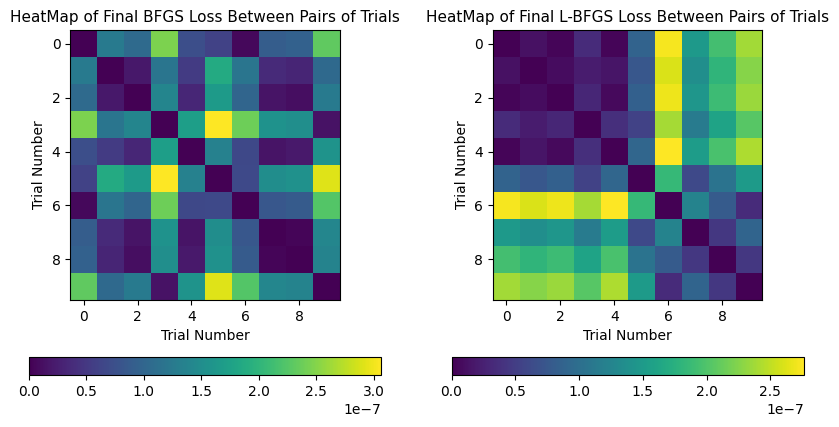

In [ ]:
# Plots for the 10 trials
figure, axes = plt.subplots(1, 2, figsize=(10,5))

# BFGS FINAL LOSS
all_bfgs_final_loss = np.array(all_bfgs_final_loss)
bfgs_difference_matrix = np.abs(all_bfgs_final_loss[:, np.newaxis] - all_bfgs_final_loss[np.newaxis, :])
bfgs_loss_heatmap = axes[0].imshow(bfgs_difference_matrix, cmap="viridis", interpolation="nearest")
axes[0].set_title("HeatMap of Final BFGS Loss Between Pairs of Trials", fontsize=11)
axes[0].set_xlabel("Trial Number")
axes[0].set_ylabel("Trial Number")
bfgs_loss_cbar = figure.colorbar(bfgs_loss_heatmap, ax=axes[0], orientation="horizontal")

# LBFGS FINAL LOSS HEATMAP
all_lbfgs_final_loss = np.array(all_lbfgs_final_loss)
lbfgs_difference_matrix = np.abs(all_lbfgs_final_loss[:, np.newaxis] - all_lbfgs_final_loss[np.newaxis, :])
lbfgs_loss_heatmap = axes[1].imshow(lbfgs_difference_matrix, cmap="viridis", interpolation="nearest")
axes[1].set_title("HeatMap of Final L-BFGS Loss Between Pairs of Trials", fontsize=11)
axes[1].set_xlabel("Trial Number")
axes[1].set_ylabel("Trial Number")
lbfgs_loss_cbar = figure.colorbar(lbfgs_loss_heatmap, ax=axes[1], orientation="horizontal")

Text(0, 0.5, 'Trial Number')

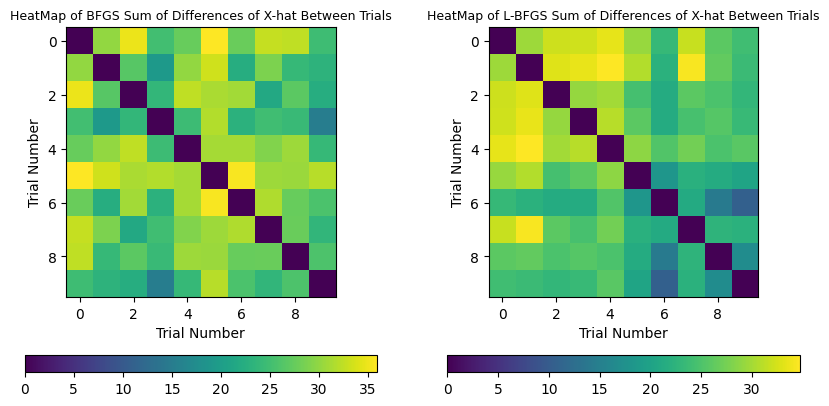

In [ ]:
# HeatMap of Differences between predicted X matrix
predict_figure, predict_axis = plt.subplots(1, 2, figsize=(10,5))

# BFGS Predicted X Difference
bfgs_sum_of_diffs = np.zeros((10,10))
for x in range(10):
  for y in range(x+1, 10):
    abs_bfgs_diff = np.abs(all_bfgs_predict_array[x] - all_bfgs_predict_array[y])
    bfgs_sum_of_diffs[x, y] = np.sum(abs_bfgs_diff)
    bfgs_sum_of_diffs[y, x] = bfgs_sum_of_diffs[x,y]

bfgs_predict_diff = predict_axis[0].imshow(bfgs_sum_of_diffs, cmap="viridis", interpolation="nearest")
bfgs_predict_cbar = predict_figure.colorbar(bfgs_predict_diff, ax=predict_axis[0], orientation="horizontal")
predict_axis[0].set_title("HeatMap of BFGS Sum of Differences of X-hat Between Trials", fontsize=9)
predict_axis[0].set_xlabel("Trial Number")
predict_axis[0].set_ylabel("Trial Number")

# BFGS Predicted X Difference
lbfgs_sum_of_diffs = np.zeros((10,10))
for x in range(10):
  for y in range(x+1, 10):
    abs_lbfgs_diff = np.abs(all_lbfgs_predict_array[x] - all_lbfgs_predict_array[y])
    lbfgs_sum_of_diffs[x, y] = np.sum(abs_lbfgs_diff)
    lbfgs_sum_of_diffs[y, x] = lbfgs_sum_of_diffs[x,y]

lbfgs_predict_diff = predict_axis[1].imshow(lbfgs_sum_of_diffs, cmap="viridis", interpolation="nearest")
lbfgs_predict_cbar = predict_figure.colorbar(lbfgs_predict_diff, ax=predict_axis[1], orientation="horizontal")
predict_axis[1].set_title("HeatMap of L-BFGS Sum of Differences of X-hat Between Trials", fontsize=9)
predict_axis[1].set_xlabel("Trial Number")
predict_axis[1].set_ylabel("Trial Number")


0.0012005212720525684


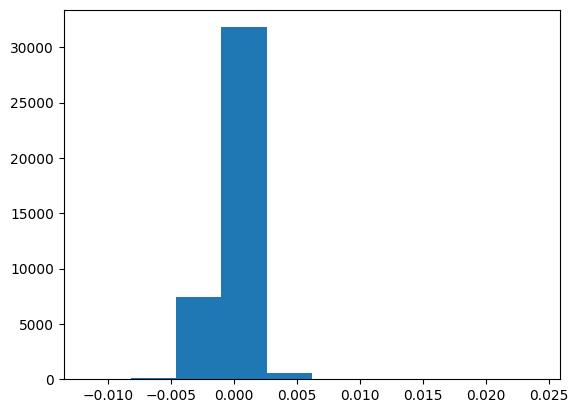

In [ ]:
# X_hat = R_1[:, np.newaxis] + C_1 + U_1 @ V_1.T
# X_hat

# X_hat_l = l_R_1[:, np.newaxis] + l_C_1 + l_U_1 @ l_V_1.T
# #print(list(X_hat_l))

# # print(X_hat)
# # print(X_hat_l)
# print(np.sqrt(np.mean((X_hat - X_hat_l)**2)))
# diff = X_hat - X_hat_l
# masked = np.isnan(X_config1)
# X_hat = X_hat[~masked]
# plt.hist(diff.ravel().flat)

# X_hat_l = X_hat_l[~masked]

# plt.plot(X_hat_l.ravel(), lbfgs_new.ravel(), "o")
# plt.plot(X_hat.ravel(), X_new.ravel(), "o")

Loss Plot For SETUP 1:

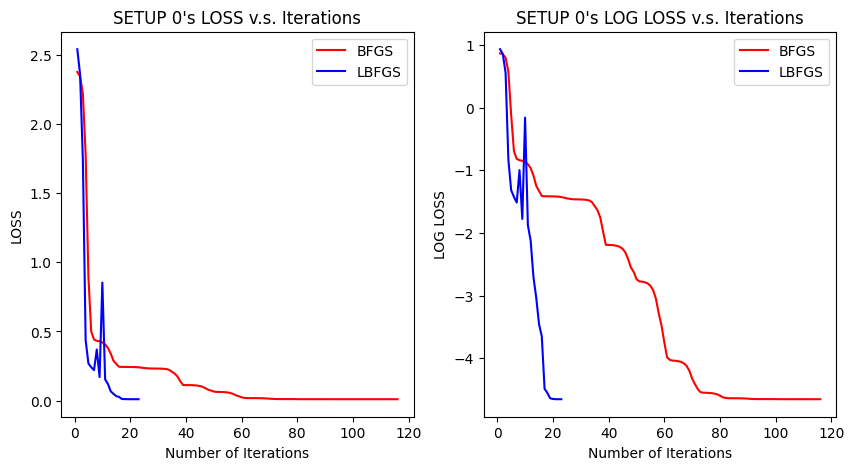

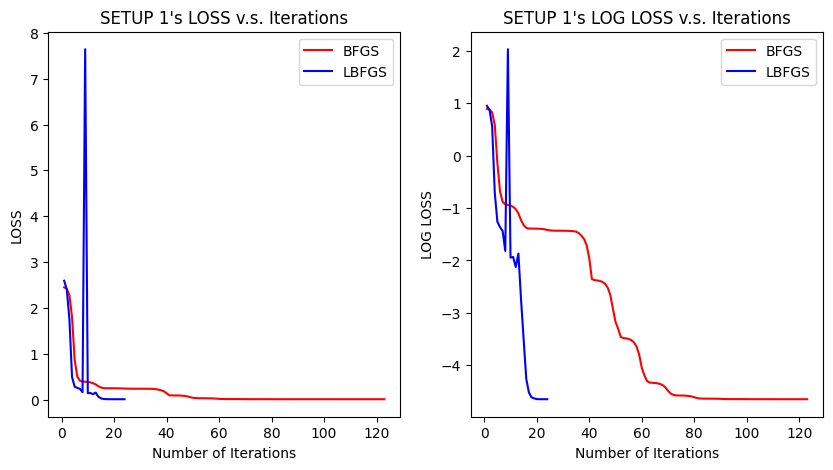

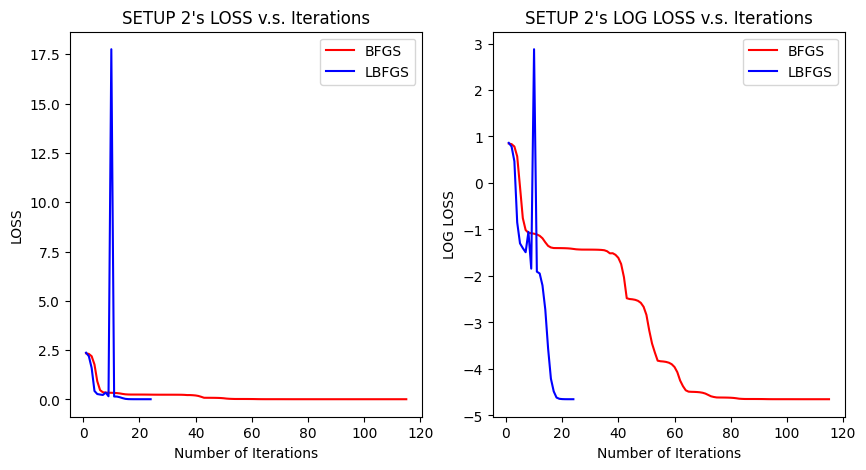

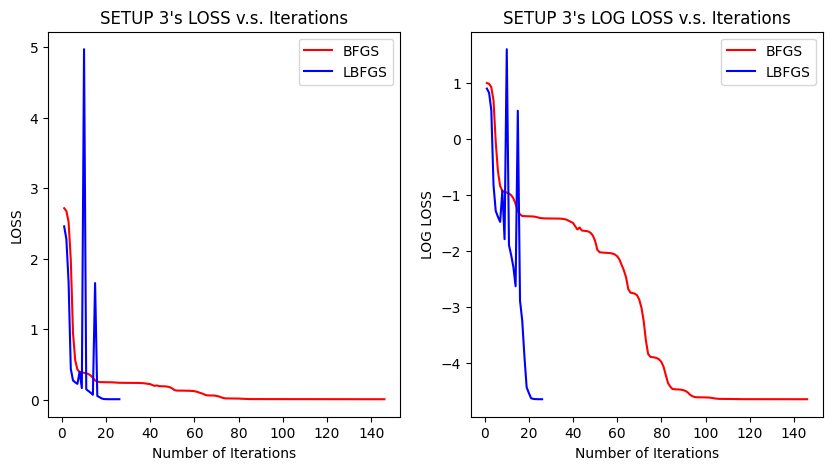

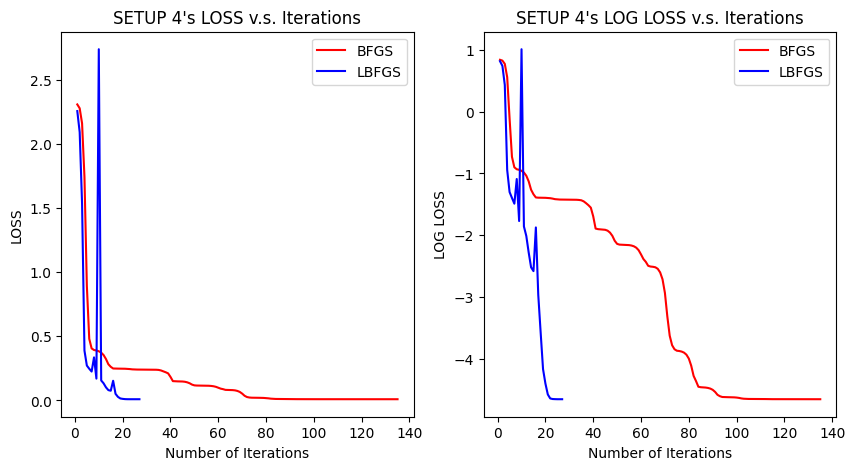

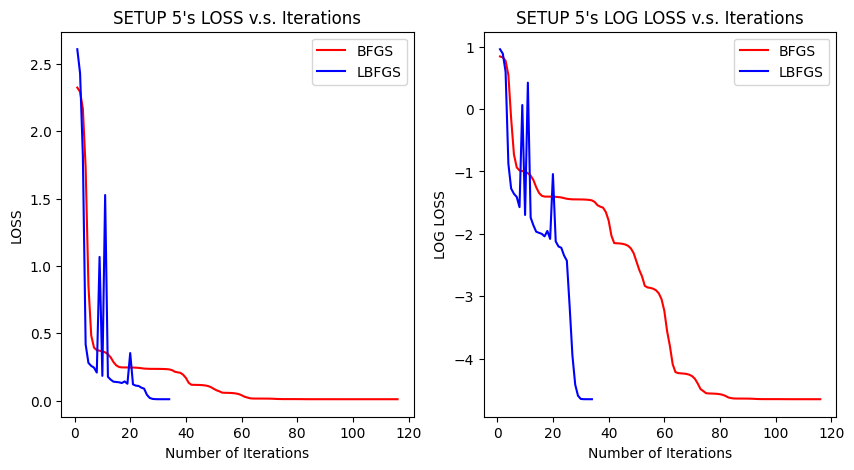

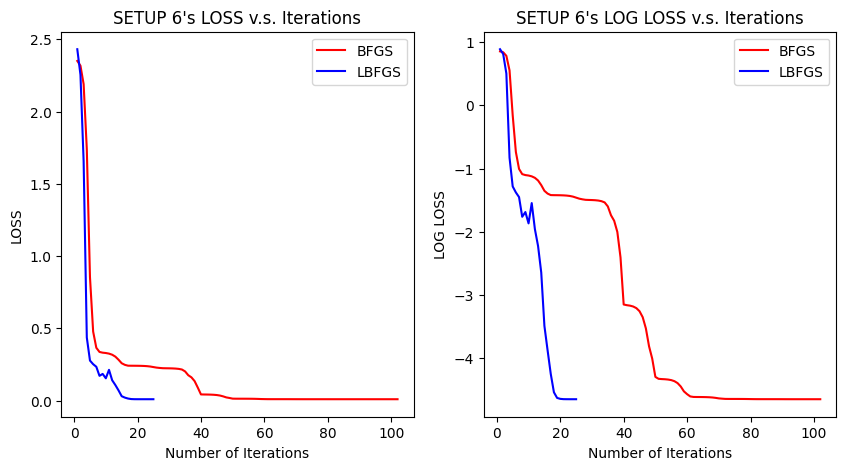

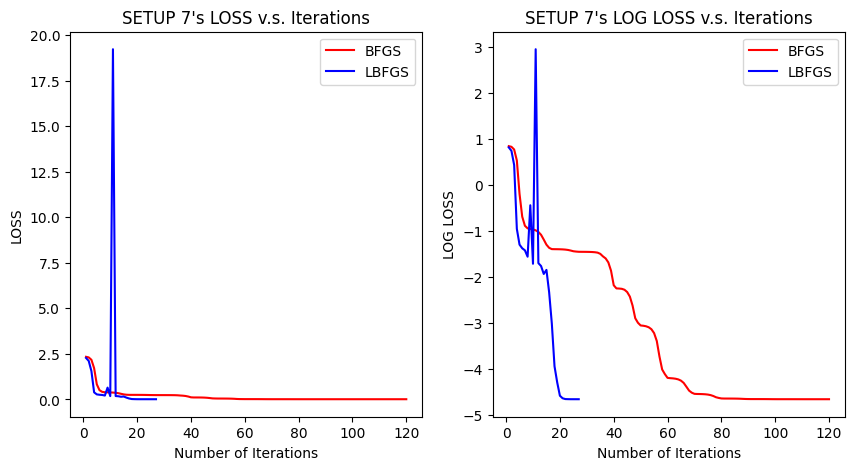

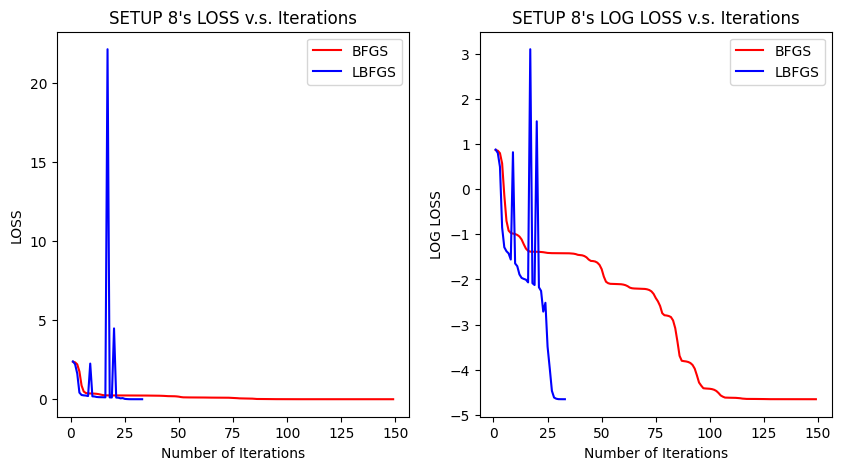

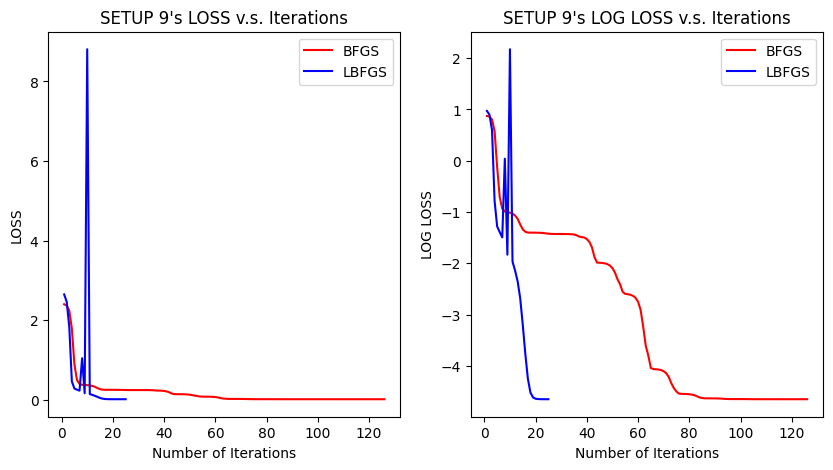

In [ ]:
# SETUP 1 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays[i], all_lbfgs_loss_arrays[i])

# SETUP 2
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 40
* True R SD: 1
* True C Mean: 40
* True C SD: 1
* True U/V Mean: 0
* True U/V STD: 0.1
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 2
* Seed: 100

Initialization:
* All INIT
* Mu: 60
* SD: 10

Expectile:
* Tau: 0.6



In [ ]:
# SETUP 2:
#----------
# Configuration: 1
# Initialization: ALL, Mu: 60, SD: 10
# Tau: 0.6
#----------
rank_2 = 2
tau_2 = 0.6
mu_2 = 60
sd_2 = 10

loss_array_2 = []
lbfgs_loss_array_2 = []
R_2, C_2, U_2, V_2, l_R_2, l_C_2, l_U_2, l_V_2 = runner_all_init(2, X_config1, rank_2, tau_2, loss_array_2, lbfgs_loss_array_2, mu_2, sd_2)

Loss Plot For SETUP 2:

In [ ]:
# SETUP 2 Plot
plotter(2, loss_array_2, lbfgs_loss_array_2)

# SETUP 3
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 30
* True R SD: 1
* True C Mean: 30
* True C SD: 1
* True U Mean: 5
* True V Mean: 4
* True U/V STD: 5
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 4
* Seed: 200

Initialization:
* All INIT
* Mu: 25
* SD: 10

Expectile:
* Tau: 0.6


In [ ]:
# SETUP 3:
#----------
# Configuration: 2
# Initialization: ALL, Mu: 25, SD: 10
# Tau: 0.6
#----------
rank_3 = 4
tau_3 = 0.6
mu_3 = 25
sd_3 = 10

loss_array_3 = []
lbfgs_loss_array_3 = []
R_3, C_3, U_3, V_3, l_R_3, l_C_3, l_U_3, l_V_3 = runner_all_init(3, X_config2, rank_3, tau_3, loss_array_3, lbfgs_loss_array_3, mu_3, sd_3)

Loss Plot For Setup 3

In [ ]:
# SETUP 3 Plot
plotter(3, loss_array_3, lbfgs_loss_array_3)

# SETUP 4
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 30
* True R SD: 1
* True C Mean: 30
* True C SD: 1
* True U Mean: 5
* True V Mean: 4
* True U/V STD: 5
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 4
* Seed: 200

Initialization:
* Sep INIT
* R_Mu: 15
* R_SD: 3
* C_Mu: 10
* C_SD: 2
* U_Mu: 15
* U_SD: 4.5
* V_Mu: 2.5
* V_SD: 1

Expectile:
* Tau: 0.6


In [ ]:
# SETUP 4:
#----------
# Configuration: 2
# Initialization: SEP, R_Mu: 15, R_SD: 3, C_Mu:10, U_Mu: 15, U_SD: 4.5, V_Mu: 2.5, V_SD: 1
# Tau: 0.6
#----------
rank_4 = 4
tau_4 = 0.6
r_mu_4 = 15
r_sd_4 = 3
c_mu_4 = 10
c_sd_4 = 2
u_mu_4 = 15
u_sd_4 = 4.5
v_mu_4 = 2.5
v_sd_4 = 1

loss_array_4 = []
lbfgs_loss_array_4 = []
R_4, C_4, U_4, V_4, l_R_4, l_C_4, l_U_4, l_V_4 = runner_sep_init(4, X_config2, rank_4, tau_4, loss_array_4, lbfgs_loss_array_4, r_mu_4, r_sd_4, c_mu_4, c_sd_4, u_mu_4, u_sd_4, v_mu_4, v_sd_4)

Loss Plot for SETUP 4

In [ ]:
# SETUP PLOT 4
plotter(4, loss_array_4, lbfgs_loss_array_4)

# SETUP 5
Configuration:


* Matrix Size: 200 * 200
* True R Mean: 5
* True R SD: 1.5
* True C Mean: -4
* True C SD: 1.5
* True U Mean: 12
* True U SD: 6
* True V Mean: 7
* True V STD: 3
* Sigma = 0.3
* Missing Proportion: 0.3
* Rank: 3
* Seed: 489

Initialization:
* Sep INIT
* R_Mu: 15
* R_SD: 3
* C_Mu: 10
* C_SD: 2
* U_Mu: 15
* U_SD: 4.5
* V_Mu: 2.5
* V_SD: 1

Expectile:
* Tau: 0.6


In [ ]:
# SETUP 5:
#----------
# Configuration: 3
# Initialization: SEP, R_Mu: 15, R_SD: 3, C_Mu:10, U_Mu: 15, U_SD: 4.5, V_Mu: 2.5, V_SD: 1
# Tau: 0.6
#----------
rank_5 = 4
tau_5 = 0.6
r_mu_5 = 15
r_sd_5 = 3
c_mu_5 = 10
c_sd_5 = 2
u_mu_5 = 15
u_sd_5 = 4.5
v_mu_5 = 2.5
v_sd_5 = 1

loss_array_5 = []
lbfgs_loss_array_5 = []
R_5, C_5, U_5, V_5, l_R_5, l_C_5, l_U_5, l_V_5 = runner_sep_init(5, X_config3, rank_5, tau_5, loss_array_5, lbfgs_loss_array_5, r_mu_5, r_sd_5, c_mu_5, c_sd_5, u_mu_5, u_sd_5, v_mu_5, v_sd_5)

Loss Plot for SETUP 5

In [ ]:
# SETUP PLOT 5
plotter(5, loss_array_5, lbfgs_loss_array_5)

In [ ]:
# X_hat = R[:, np.newaxis] + C + U @ V.T
# X_hat

# X_hat_l = R_l[:, np.newaxis] + C_l, + U_l @ V_l.T
# X_hat_l

In [ ]:
# print("BFGS Feature Difference: ", X_hat - mu_X)
# #type(X_hat)
# #X_hat.shape
# residual = (X_hat - mu_X).ravel().std()
# print("BFGS Residual: ", residual)
# #type(residual)
# # plt.hist(residual)
# print("LBFGS Featrue Difference: ", X_hat_l - mu_X)
# residual_l = (X_hat_l - mu_X).ravel().std()
# print("LBFGS Residual: ", residual_l)

In [ ]:
# print("BFGS R's diff: ",true_r - R)
# print("LBFGS R's diff: ", true_r - R_l)

In [ ]:
# print("BFGS C's difference: ", true_c - C)
# print("LBFGS C's difference: ", true_c - C_l)

In [ ]:
# print("BFGS difference in outer: ", np.outer(U, V) - np.outer(true_u, true_v))
# print("LBFGS difference in outer: ", np.outer(U_l, V_l) - np.outer(true_u, true_v))